# 数据预处理

In [1]:
import os
import numpy as np
import cv2
import torch
from torch import nn
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
factor = 2  #倍率

In [3]:
def upsize(input_path, output_path, high_path):
    img1 = Image.open(input_path)
    img2 = Image.open(high_path)
    new_width, new_height = img2.size
   
    resized_img = img1.resize((new_width, new_height), Image.BICUBIC)
    resized_img.save(output_path)

In [58]:
#input_dir = r'D:\learncourse\BigChuang\dataset\test_img\lr'
#output_dir = r'D:\learncourse\BigChuang\dataset\test_img\lr'
#high_dir = r'D:\learncourse\BigChuang\dataset\test_img\hr'
input_dir = r'D:\learncourse\BigChuang\dataset\train_img\lr'
output_dir = r'D:\learncourse\BigChuang\dataset\train_img\lr'
high_dir = r'D:\learncourse\BigChuang\dataset\train_img\hr'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

for i in range(100):
    # 构建输入和输出路径
    if(i<9):
        input_image_path = os.path.join(input_dir, f'000{i+1}.png')  # 假设文件扩展名为 .png
    elif(i<99):
        input_image_path = os.path.join(input_dir, f'00{i+1}.png')
    else:
        input_image_path = os.path.join(input_dir, f'0100.png')
    if(i<9):
        output_image_path = os.path.join(output_dir, f'000{i+1}.png')  # 保存为 .png 文件
    elif(i<99):
        #if i == 10: print(f'00{i+1}')
        output_image_path = os.path.join(output_dir, f'00{i+1}.png')
    else:
        input_image_path = os.path.join(input_dir, f'0100.png')
    print(output_image_path)

    # 检查输入文件是否存在
    if not os.path.exists(input_image_path):
        print(f"Input image {input_image_path} does not exist. Skipping...")
        continue

    upsize(input_image_path, output_image_path, high_image_path)

print("Image downscaling completed.")

D:\learncourse\BigChuang\dataset\train_img\lr\0001.png
D:\learncourse\BigChuang\dataset\train_img\lr\0002.png
D:\learncourse\BigChuang\dataset\train_img\lr\0003.png
D:\learncourse\BigChuang\dataset\train_img\lr\0004.png
D:\learncourse\BigChuang\dataset\train_img\lr\0005.png
D:\learncourse\BigChuang\dataset\train_img\lr\0006.png
D:\learncourse\BigChuang\dataset\train_img\lr\0007.png
D:\learncourse\BigChuang\dataset\train_img\lr\0008.png
D:\learncourse\BigChuang\dataset\train_img\lr\0009.png
D:\learncourse\BigChuang\dataset\train_img\lr\0010.png
D:\learncourse\BigChuang\dataset\train_img\lr\0011.png
D:\learncourse\BigChuang\dataset\train_img\lr\0012.png
D:\learncourse\BigChuang\dataset\train_img\lr\0013.png
D:\learncourse\BigChuang\dataset\train_img\lr\0014.png
D:\learncourse\BigChuang\dataset\train_img\lr\0015.png
D:\learncourse\BigChuang\dataset\train_img\lr\0016.png
D:\learncourse\BigChuang\dataset\train_img\lr\0017.png
D:\learncourse\BigChuang\dataset\train_img\lr\0018.png
D:\learnco

In [4]:
# 自定义 Dataset 类
class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.lr_dir = os.path.join(root_dir, 'lr')
        self.hr_dir = os.path.join(root_dir, 'hr')
        self.image_names = sorted(os.listdir(self.lr_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        lr_path = os.path.join(self.lr_dir, img_name)
        hr_path = os.path.join(self.hr_dir, img_name)

        lr_image = Image.open(lr_path).convert('RGB')
        hr_image = Image.open(hr_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [5]:
# 定义转换操作
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整图片大小
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),          # 转换为张量
])

# 加载训练集和测试集
dataset = SRDataset(root_dir=r'D:\learncourse\BigChuang\dataset\test_img', transform=transform)
train_dataset = SRDataset(root_dir=r'D:\learncourse\BigChuang\dataset\train_img', transform=transform)

val_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

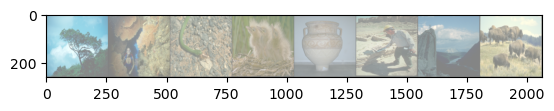

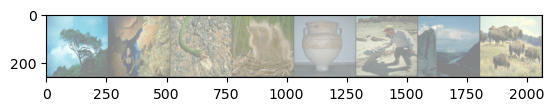

In [6]:
# 从 train_loader 获取一批数据
lr, hr = next(iter(train_loader))

# 展示这一批图像
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 显示一个批次中的前 8 张图像
imshow(torchvision.utils.make_grid(lr[:8], nrow=8))
imshow(torchvision.utils.make_grid(hr[:8], nrow=8))

# 模型构建

In [14]:
class ConvReLUBlock(nn.Module):
    def __init__(self):
        super(ConvReLUBlock,self).__init__()
        self.conv = nn.Conv2d(
                in_channels = 64,
                out_channels = 64, 
                kernel_size = (3,3),
                stride = (1,1),
                padding = (1,1),
                #bias = False
            )
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return x

In [15]:
class vdsr(nn.Module):
    def __init__(self):
        super(vdsr,self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,#灰度
            out_channels = 64, 
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1),
            #bias = False
        )
        self.relu1 = nn.ReLU(inplace = True)
        self.residual_layer = self.make_layer(ConvReLUBlock, 18)
        self.conv20 = nn.Conv2d(64, 3, (3, 3), (1, 1), (1, 1))

    def make_layer(self, block, num):
        layers = []
        for i in range(num):
            layers.append(block())
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.residual_layer(out)
        out = self.conv20(out)
        out = torch.add(out, x)
        return out

# 准备参数进行训练

In [19]:
from torch.optim import lr_scheduler
import torch.optim
from tqdm import tqdm
import copy

In [21]:
class config:
    epochs = 80
    device = "cpu"
    model_lr = 0.1  #学习率
    model_momentum = 0.9  #动量
    model_weight_decay = 1e-4  #L2正则化
    model_nesterov = False  #是否使用nesterov动量
    lr_scheduler_step_size = epochs // 4  #每隔多少个 epoch 更新一次学习率
    lr_scheduler_gamma = 0.1

In [23]:
model = vdsr()
model

vdsr(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (residual_layer): Sequential(
    (0): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (1): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (2): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (3): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (4): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (5): ConvReLUBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    

In [25]:
loss_fc = nn.MSELoss(reduction = "mean").to(config.device)
    
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = config.model_lr, 
                            momentum = config.model_momentum, 
                            weight_decay=config.model_weight_decay,
                            nesterov = config.model_nesterov)
scheduler = lr_scheduler.StepLR(optimizer, step_size=config.lr_scheduler_step_size, gamma=config.lr_scheduler_gamma)
    
psnr_criterion = nn.MSELoss().to(config.device)

# 定义训练函数

In [28]:
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fc:torch.nn.Module,
               psnr_criterion,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
    
    train_loss, train_psnr =0.0, 0.0
    model.to(device)
    model.train()
    
    for batch, (lr, hr) in enumerate(data_loader):
        lr, hr = lr.to(device), hr.to(device)
        
        sr = model(lr)
        loss = loss_fc(sr, hr)
        train_loss += loss
        train_psnr += 10. * torch.log10(1. / psnr_criterion(sr, hr))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(train_loss, train_psnr)

    train_loss /= len(data_loader)
    train_psnr /= len(data_loader)
    print(f"train loss: {train_loss:.5f} | train psnr: {train_psnr:.2f}")

In [30]:
def valid_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fc:torch.nn.Module,
               psnr_criterion,
               device:torch.device):
    
    train_loss, train_psnr =0.0, 0.0
    model.to(device)
    model.eval()

    with torch.no_grad():  #禁止梯度计算
        for batch, (lr, hr) in enumerate(data_loader):
            lr, hr = lr.to(device), hr.to(device)
            
            sr = model(lr)
            loss = loss_fc(sr, hr)
            train_loss += loss
            train_psnr += 10. * torch.log10(1. / psnr_criterion(sr, hr))

    train_loss /= len(data_loader)
    train_psnr /= len(data_loader)
    print(f"valid loss: {train_loss:.5f} | valid psnr: {train_psnr:.2f}")
    return train_psnr

In [32]:
psnr = 0.0
best_epoch = 0
best_weights = copy.deepcopy(model.state_dict())
for epoch in tqdm(range(config.epochs), unit="epoch"):
    print(f"epoch: {epoch + 1}\n---------")
    train_step(model, train_loader, loss_fc, psnr_criterion, optimizer, config.device)
    p = valid_step(model, val_loader, loss_fc, psnr_criterion, config.device)
    if p > psnr:
        best_epoch = epoch + 1
        psnr = p
        best_weights = copy.deepcopy(model.state_dict())
    #test_step(model, val_loader, loss_fc, psnr_criterion, config.device)
    scheduler.step()
print(f"best epoch:{best_epoch}, psnr:{psnr}")
torch.save(best_weights, "model_state_dict.pth")

  0%|                                                                                        | 0/80 [00:00<?, ?epoch/s]

epoch: 1
---------
train loss: 0.00049 | train psnr: 33.20


  1%|▉                                                                            | 1/80 [02:01<2:39:24, 121.07s/epoch]

valid loss: 0.00044 | valid psnr: 33.57
epoch: 2
---------
train loss: 0.00046 | train psnr: 33.43


  2%|█▉                                                                           | 2/80 [04:08<2:42:17, 124.84s/epoch]

valid loss: 0.00039 | valid psnr: 34.06
epoch: 3
---------
train loss: 0.00044 | train psnr: 33.65


  4%|██▉                                                                          | 3/80 [06:20<2:44:27, 128.14s/epoch]

valid loss: 0.00039 | valid psnr: 34.10
epoch: 4
---------
train loss: 0.00043 | train psnr: 33.73


  5%|███▊                                                                         | 4/80 [08:32<2:44:04, 129.53s/epoch]

valid loss: 0.00039 | valid psnr: 34.08
epoch: 5
---------
train loss: 0.00043 | train psnr: 33.78


  6%|████▊                                                                        | 5/80 [10:44<2:43:12, 130.56s/epoch]

valid loss: 0.00039 | valid psnr: 34.08
epoch: 6
---------
train loss: 0.00043 | train psnr: 33.79


  8%|█████▊                                                                       | 6/80 [12:56<2:41:21, 130.83s/epoch]

valid loss: 0.00039 | valid psnr: 34.10
epoch: 7
---------
train loss: 0.00043 | train psnr: 33.82


  9%|██████▋                                                                      | 7/80 [15:07<2:39:37, 131.19s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 8
---------
train loss: 0.00043 | train psnr: 33.81


 10%|███████▋                                                                     | 8/80 [17:19<2:37:40, 131.40s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 9
---------
train loss: 0.00043 | train psnr: 33.82


 11%|████████▋                                                                    | 9/80 [19:35<2:36:58, 132.65s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 10
---------
train loss: 0.00043 | train psnr: 33.80


 12%|█████████▌                                                                  | 10/80 [21:50<2:35:50, 133.58s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 11
---------
train loss: 0.00043 | train psnr: 33.77


 14%|██████████▍                                                                 | 11/80 [24:06<2:34:19, 134.20s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 12
---------
train loss: 0.00043 | train psnr: 33.80


 15%|███████████▍                                                                | 12/80 [26:21<2:32:28, 134.53s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 13
---------
train loss: 0.00043 | train psnr: 33.82


 16%|████████████▎                                                               | 13/80 [28:37<2:30:30, 134.79s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 14
---------
train loss: 0.00043 | train psnr: 33.75


 18%|█████████████▎                                                              | 14/80 [30:53<2:28:46, 135.25s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 15
---------
train loss: 0.00043 | train psnr: 33.74


 19%|██████████████▎                                                             | 15/80 [33:08<2:26:27, 135.19s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 16
---------
train loss: 0.00043 | train psnr: 33.82


 20%|███████████████▏                                                            | 16/80 [35:24<2:24:18, 135.29s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 17
---------
train loss: 0.00043 | train psnr: 33.80


 21%|████████████████▏                                                           | 17/80 [37:39<2:22:05, 135.32s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 18
---------
train loss: 0.00043 | train psnr: 33.78


 22%|█████████████████                                                           | 18/80 [39:54<2:19:48, 135.29s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 19
---------
train loss: 0.00043 | train psnr: 33.79


 24%|██████████████████                                                          | 19/80 [42:09<2:17:22, 135.12s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 20
---------
train loss: 0.00043 | train psnr: 33.73


 25%|███████████████████                                                         | 20/80 [44:24<2:15:05, 135.09s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 21
---------
train loss: 0.00043 | train psnr: 33.78


 26%|███████████████████▉                                                        | 21/80 [46:38<2:12:41, 134.94s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 22
---------
train loss: 0.00043 | train psnr: 33.79


 28%|████████████████████▉                                                       | 22/80 [48:53<2:10:17, 134.79s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 23
---------
train loss: 0.00043 | train psnr: 33.78


 29%|█████████████████████▊                                                      | 23/80 [51:08<2:08:01, 134.76s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 24
---------
train loss: 0.00043 | train psnr: 33.75


 30%|██████████████████████▊                                                     | 24/80 [53:22<2:05:36, 134.57s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 25
---------
train loss: 0.00043 | train psnr: 33.75


 31%|███████████████████████▊                                                    | 25/80 [55:37<2:03:26, 134.67s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 26
---------
train loss: 0.00043 | train psnr: 33.76


 32%|████████████████████████▋                                                   | 26/80 [57:51<2:01:13, 134.70s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 27
---------
train loss: 0.00043 | train psnr: 33.87


 34%|████████████████████████▉                                                 | 27/80 [1:00:06<1:59:00, 134.72s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 28
---------
train loss: 0.00043 | train psnr: 33.78


 35%|█████████████████████████▉                                                | 28/80 [1:02:21<1:56:43, 134.68s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 29
---------
train loss: 0.00043 | train psnr: 33.78


 36%|██████████████████████████▊                                               | 29/80 [1:04:36<1:54:30, 134.72s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 30
---------
train loss: 0.00043 | train psnr: 33.86


 38%|███████████████████████████▊                                              | 30/80 [1:06:50<1:52:08, 134.57s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 31
---------
train loss: 0.00043 | train psnr: 33.78


 39%|████████████████████████████▋                                             | 31/80 [1:09:04<1:49:42, 134.34s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 32
---------
train loss: 0.00043 | train psnr: 33.73


 40%|█████████████████████████████▌                                            | 32/80 [1:11:19<1:47:41, 134.62s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 33
---------
train loss: 0.00043 | train psnr: 33.80


 41%|██████████████████████████████▌                                           | 33/80 [1:13:31<1:44:54, 133.92s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 34
---------
train loss: 0.00043 | train psnr: 33.78


 42%|███████████████████████████████▍                                          | 34/80 [1:15:44<1:42:19, 133.46s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 35
---------
train loss: 0.00043 | train psnr: 33.75


 44%|████████████████████████████████▍                                         | 35/80 [1:17:55<1:39:40, 132.89s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 36
---------
train loss: 0.00043 | train psnr: 33.79


 45%|█████████████████████████████████▎                                        | 36/80 [1:20:08<1:37:26, 132.87s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 37
---------
train loss: 0.00043 | train psnr: 33.77


 46%|██████████████████████████████████▏                                       | 37/80 [1:22:22<1:35:24, 133.12s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 38
---------
train loss: 0.00043 | train psnr: 33.77


 48%|███████████████████████████████████▏                                      | 38/80 [1:24:35<1:33:14, 133.19s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 39
---------
train loss: 0.00043 | train psnr: 33.93


 49%|████████████████████████████████████                                      | 39/80 [1:26:49<1:31:07, 133.36s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 40
---------
train loss: 0.00043 | train psnr: 33.79


 50%|█████████████████████████████████████                                     | 40/80 [1:29:02<1:28:53, 133.35s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 41
---------
train loss: 0.00043 | train psnr: 33.74


 51%|█████████████████████████████████████▉                                    | 41/80 [1:31:15<1:26:34, 133.18s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 42
---------
train loss: 0.00043 | train psnr: 33.75


 52%|██████████████████████████████████████▊                                   | 42/80 [1:33:28<1:24:17, 133.10s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 43
---------
train loss: 0.00043 | train psnr: 33.83


 54%|███████████████████████████████████████▊                                  | 43/80 [1:35:41<1:22:04, 133.08s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 44
---------
train loss: 0.00043 | train psnr: 33.74


 55%|████████████████████████████████████████▋                                 | 44/80 [1:37:54<1:19:52, 133.14s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 45
---------
train loss: 0.00043 | train psnr: 33.81


 56%|█████████████████████████████████████████▋                                | 45/80 [1:40:07<1:17:42, 133.21s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 46
---------
train loss: 0.00043 | train psnr: 33.77


 57%|██████████████████████████████████████████▌                               | 46/80 [1:42:21<1:15:33, 133.34s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 47
---------
train loss: 0.00043 | train psnr: 33.78


 59%|███████████████████████████████████████████▍                              | 47/80 [1:44:34<1:13:20, 133.35s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 48
---------
train loss: 0.00043 | train psnr: 33.87


 60%|████████████████████████████████████████████▍                             | 48/80 [1:46:48<1:11:05, 133.30s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 49
---------
train loss: 0.00043 | train psnr: 33.86


 61%|█████████████████████████████████████████████▎                            | 49/80 [1:49:02<1:09:01, 133.60s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 50
---------
train loss: 0.00043 | train psnr: 33.82


 62%|██████████████████████████████████████████████▎                           | 50/80 [1:54:01<1:31:36, 183.23s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 51
---------
train loss: 0.00043 | train psnr: 33.88


 64%|███████████████████████████████████████████████▏                          | 51/80 [1:56:04<1:19:51, 165.21s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 52
---------
train loss: 0.00043 | train psnr: 33.84


 65%|████████████████████████████████████████████████                          | 52/80 [1:58:14<1:12:12, 154.74s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 53
---------
train loss: 0.00043 | train psnr: 33.78


 66%|█████████████████████████████████████████████████                         | 53/80 [2:00:23<1:06:02, 146.77s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 54
---------
train loss: 0.00043 | train psnr: 33.77


 68%|█████████████████████████████████████████████████▉                        | 54/80 [2:02:33<1:01:29, 141.89s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 55
---------
train loss: 0.00043 | train psnr: 33.78


 69%|████████████████████████████████████████████████████▎                       | 55/80 [2:04:49<58:25, 140.22s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 56
---------
train loss: 0.00043 | train psnr: 33.78


 70%|█████████████████████████████████████████████████████▏                      | 56/80 [2:07:26<58:01, 145.07s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 57
---------
train loss: 0.00043 | train psnr: 33.76


 71%|██████████████████████████████████████████████████████▏                     | 57/80 [2:09:46<54:59, 143.44s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 58
---------
train loss: 0.00043 | train psnr: 33.80


 72%|███████████████████████████████████████████████████████                     | 58/80 [2:11:58<51:22, 140.11s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 59
---------
train loss: 0.00043 | train psnr: 33.79


 74%|████████████████████████████████████████████████████████                    | 59/80 [2:14:10<48:10, 137.65s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 60
---------
train loss: 0.00043 | train psnr: 33.76


 75%|█████████████████████████████████████████████████████████                   | 60/80 [2:16:24<45:30, 136.51s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 61
---------
train loss: 0.00043 | train psnr: 33.81


 76%|█████████████████████████████████████████████████████████▉                  | 61/80 [2:18:37<42:54, 135.49s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 62
---------
train loss: 0.00043 | train psnr: 33.77


 78%|██████████████████████████████████████████████████████████▉                 | 62/80 [2:20:52<40:37, 135.43s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 63
---------
train loss: 0.00043 | train psnr: 33.76


 79%|███████████████████████████████████████████████████████████▊                | 63/80 [2:23:20<39:27, 139.24s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 64
---------
train loss: 0.00043 | train psnr: 33.80


 80%|████████████████████████████████████████████████████████████▊               | 64/80 [2:25:40<37:10, 139.42s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 65
---------
train loss: 0.00043 | train psnr: 33.79


 81%|█████████████████████████████████████████████████████████████▊              | 65/80 [2:27:55<34:30, 138.05s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 66
---------
train loss: 0.00043 | train psnr: 33.76


 82%|██████████████████████████████████████████████████████████████▋             | 66/80 [2:30:07<31:47, 136.28s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 67
---------
train loss: 0.00043 | train psnr: 33.76


 84%|███████████████████████████████████████████████████████████████▋            | 67/80 [2:32:29<29:52, 137.88s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 68
---------
train loss: 0.00043 | train psnr: 33.74


 85%|████████████████████████████████████████████████████████████████▌           | 68/80 [2:34:48<27:40, 138.34s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 69
---------
train loss: 0.00043 | train psnr: 33.90


 86%|█████████████████████████████████████████████████████████████████▌          | 69/80 [2:37:04<25:13, 137.59s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 70
---------
train loss: 0.00043 | train psnr: 33.87


 88%|██████████████████████████████████████████████████████████████████▌         | 70/80 [2:39:22<22:56, 137.67s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 71
---------
train loss: 0.00043 | train psnr: 33.87


 89%|███████████████████████████████████████████████████████████████████▍        | 71/80 [2:41:43<20:48, 138.68s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 72
---------
train loss: 0.00043 | train psnr: 33.83


 90%|████████████████████████████████████████████████████████████████████▍       | 72/80 [2:44:01<18:28, 138.61s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 73
---------
train loss: 0.00043 | train psnr: 33.78


 91%|█████████████████████████████████████████████████████████████████████▎      | 73/80 [2:46:16<16:02, 137.46s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 74
---------
train loss: 0.00043 | train psnr: 33.88


 92%|██████████████████████████████████████████████████████████████████████▎     | 74/80 [2:48:29<13:36, 136.11s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 75
---------
train loss: 0.00043 | train psnr: 33.82


 94%|███████████████████████████████████████████████████████████████████████▎    | 75/80 [2:50:47<11:22, 136.58s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 76
---------
train loss: 0.00043 | train psnr: 33.80


 95%|████████████████████████████████████████████████████████████████████████▏   | 76/80 [2:53:04<09:07, 136.91s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 77
---------
train loss: 0.00043 | train psnr: 33.74


 96%|█████████████████████████████████████████████████████████████████████████▏  | 77/80 [2:55:21<06:50, 136.80s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 78
---------
train loss: 0.00043 | train psnr: 33.75


 98%|██████████████████████████████████████████████████████████████████████████  | 78/80 [2:57:37<04:33, 136.61s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 79
---------
train loss: 0.00043 | train psnr: 33.76


 99%|███████████████████████████████████████████████████████████████████████████ | 79/80 [2:59:54<02:16, 136.76s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
epoch: 80
---------
train loss: 0.00043 | train psnr: 33.80


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [3:02:10<00:00, 136.63s/epoch]

valid loss: 0.00039 | valid psnr: 34.11
best epoch:66, psnr:34.111454010009766


# 模型测试

In [35]:
model.load_state_dict(torch.load('model_state_dict.pth'))

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_7900\1276111990.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state_dict.pth'))


<All keys matched successfully>

In [37]:
lr, hr = next(iter(test_loader))
lr = lr[1]
hr = hr[1]

In [39]:
sr = model(lr)
psnr = 10. * torch.log10(1. / psnr_criterion(sr, hr))
print(f"sr psnr value is:{psnr}")
psnr = 10. * torch.log10(1. / psnr_criterion(lr, hr))
print(f"lr psnr value is:{psnr}")

sr psnr value is:29.62136459350586
lr psnr value is:29.62244415283203


In [41]:
np_sr = sr.detach().numpy()
np_sr = np.transpose(np_sr, (1, 2, 0))
sr = (np_sr * 255).astype(np.uint8)

cv2.imwrite('sr.jpg', cv2.cvtColor(sr, cv2.COLOR_BGR2RGB))
print("ok")

ok


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


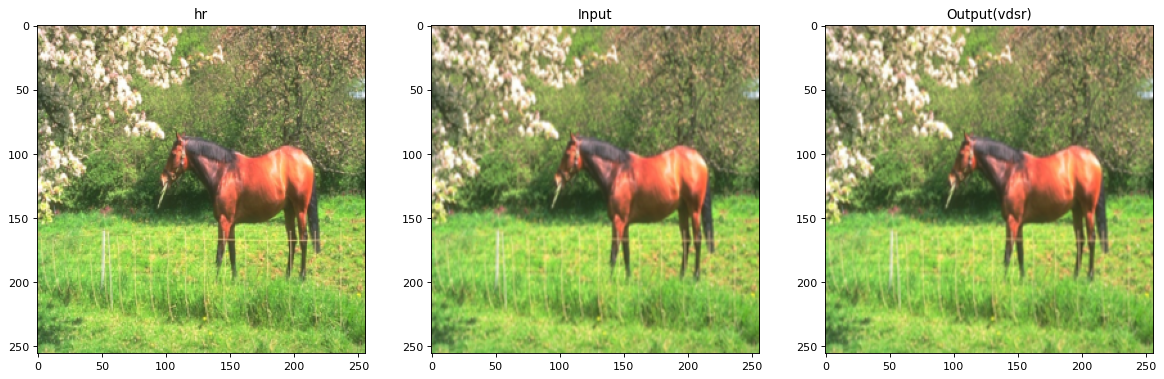

In [43]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot(131)
hrimg = hr.numpy()
plt.imshow(np.transpose(hrimg, (1, 2, 0)))
ax.set_title("hr")

ax = plt.subplot(132)
lrimg = lr.numpy()
ax.imshow(np.transpose(lrimg, (1, 2, 0)))
ax.set_title("Input")

ax = plt.subplot(133)
ax.imshow(np_sr)
ax.set_title("Output(vdsr)")
plt.show()